# True colour animations with rainfall

* **Products used:** 
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), 
[wofs_ls_summary_annual](https://explorer.digitalearth.africa/wofs_ls_summary_annual)

## Background
It is sometimes informative to visualise true colour imagery of an area through time alongside some possibly associated variable, such as rainfall. Inspecting an animated timeseries of a given area through time alongside cumulative rainfall can show how landscape features (vegetation, water bodies etc.) respond to rain events or lack thereof.

This notebook demonstrates how rainfall and true colour imagery data can be assimilated to produce informative animations.

## Description

We can use Sentinel-2 surface reflectance and CHIRPS rainfall data products to product this animation. The platform enables us to integrate these datasets within a year of interest and align them both temporally and spatially to visualise them synchronously.

The animation is produced in this notebook by following the steps below:

1. Select an area of interest.
2. Load surface reflectance (true colour) imagery.
3. Resample and interpolate imagery to generate a regular timeseries.
4. Load rainfall data.
5. Resample rainfall data to generate a regular timeseries.
6. Define axes and update function for the animation.
7. Run and interpret the animation.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import datetime as dt
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates

from IPython.display import HTML
from datacube.utils.geometry import Geometry
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='animation-rainfall')

create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:46419' processes=1 threads=2, memory=12.03 GB>

### Analysis parameters




To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button ![upload_files_icon.png](upload_files_icon.png) in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=-17.92, lon=25.85, buffer=0.05)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
#aoi = define_area(shapefile_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

display_map(lon_range, lat_range)

## Load satellite data from datacube

In [4]:
# Create a reusable query
query = {
    'x': lon_range,
    'y': lat_range,
    'time': ('2021-11-30', '2023-02-20'),
    'resolution': (-20, 20)
}

In [5]:
# Load available data
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              measurements=['red', 'green', 'blue'],
              group_by='solar_day',
              output_crs='epsg:6933', 
              min_gooddata=0.95,
              mask_pixel_quality=True,
              **query)

# Print output data
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 44 out of 85 time steps with at least 95.0% good quality pixels
Applying pixel quality/cloud mask
Loading 44 time steps
<xarray.Dataset>
Dimensions:      (time: 44, y: 609, x: 483)
Coordinates:
  * time         (time) datetime64[ns] 2021-12-03T08:35:11 ... 2023-02-11T08:...
  * y            (y) float64 -2.244e+06 -2.244e+06 ... -2.256e+06 -2.256e+06
  * x            (x) float64 2.489e+06 2.489e+06 ... 2.499e+06 2.499e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 1.304e+03 1.162e+03 ... 327.0 354.0
    green        (time, y, x) float32 1e+03 943.0 965.0 ... 586.0 552.0 560.0
    blue         (time, y, x) float32 676.0 664.0 687.0 ... 325.0 297.0 292.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [6]:
ds = ds.resample(time="2D").interpolate("linear").sel(
    time=slice('2022-01-01', '2022-12-31'))

ds

<xarray.Dataset>
Dimensions:      (time: 182, y: 609, x: 483)
Coordinates:
  * y            (y) float64 -2.244e+06 -2.244e+06 ... -2.256e+06 -2.256e+06
  * x            (x) float64 2.489e+06 2.489e+06 ... 2.499e+06 2.499e+06
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2022-01-02 2022-01-04 ... 2022-12-30
Data variables:
    red          (time, y, x) float64 985.0 820.8 955.8 994.5 ... nan nan nan
    green        (time, y, x) float64 939.1 841.2 907.0 963.4 ... nan nan nan
    blue         (time, y, x) float64 658.5 582.4 600.4 625.0 ... nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

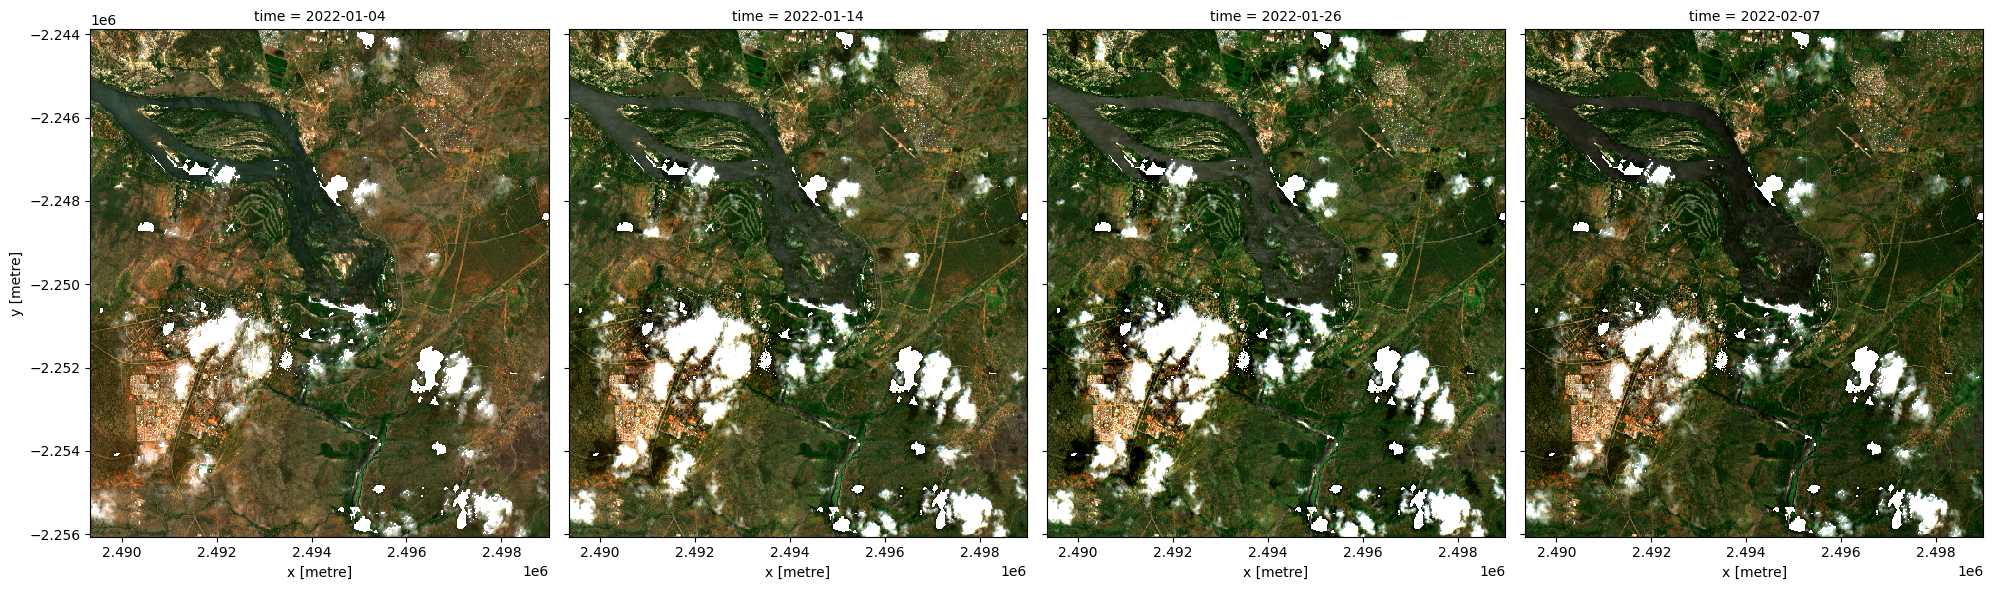

In [7]:
# Plot four images from the dataset
rgb(ds, index=[1, 6, 12, 18])

In [8]:
ds_rf_daily = dc.load(product='rainfall_chirps_daily',
                time='2022',
                y = lat_range,
                x = lon_range,
                resolution=(-5000, 5000),
                output_crs='epsg:6933')

print(ds_rf_daily)

<xarray.Dataset>
Dimensions:      (time: 335, y: 4, x: 3)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-01T11:59:59.500000 ... 2022-12...
  * y            (y) float64 -2.242e+06 -2.248e+06 -2.252e+06 -2.258e+06
  * x            (x) float64 2.488e+06 2.492e+06 2.498e+06
    spatial_ref  int32 6933
Data variables:
    rainfall     (time, y, x) float32 0.0 0.0 0.0 0.0 ... 4.389 4.435 5.132
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


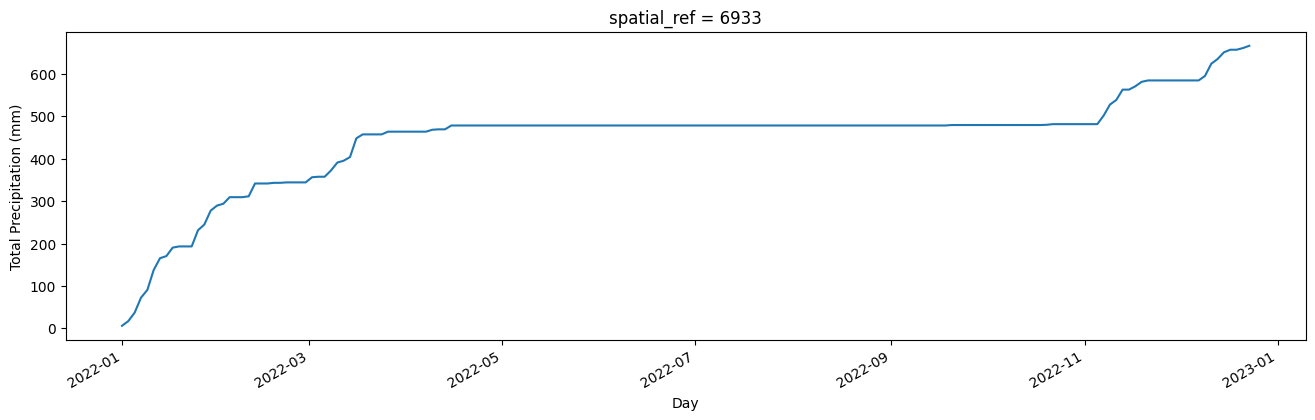

In [9]:
ds_rf_daily['rainfall'].resample(time='2D').sum().mean(['y', 'x']).cumsum().plot(figsize=(16, 4))
plt.xlabel('Day')
plt.ylabel('%s (%s)' % ('Total Precipitation', ds_rf_daily['rainfall'].attrs['units']));

In [10]:
# create a figure and axes
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(122)   
ax2 = plt.subplot(121)

ax1.set_title("Cumulative Rainfall")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Precipitation (mm)")

bands=['red', 'green', 'blue']


cax = (ds[bands].isel(time=0).to_array().transpose('y','x','variable').squeeze()/np.max(
    ds[bands].isel(time=0).to_array(
    ).transpose('y','x','variable').squeeze())).plot.imshow(rgb='variable', animated = True, robust=True)

def update(num, x, y, line):
    cax.set_array((ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,2500)/np.max(
    ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,2500))
    ax2.set_title("Time = " + str(ds[bands].coords['time'].values[(num)])[:12])
    line.set_data(x[:num], y[:num])
    return line,

x = ds_rf_daily['rainfall'].resample(time='2D').sum().mean(['y', 'x']).cumsum().time
y = ds_rf_daily['rainfall'].resample(time='2D').sum().mean(['y', 'x']).cumsum()

line, = ax1.plot(x, y)

plt.tight_layout()

ani = animation.FuncAnimation(fig, update, len(x)-4, fargs=[x, y, line],
                              interval=200, blit=True)
plt.close()
HTML(ani.to_html5_video())

## Long term annual rainfall

We can also inspect longer term rainfall patterns with annual geomedian images.

In [11]:
ds = dc.load(product=["gm_ls5_ls7_annual", "gm_ls8_annual","gm_ls8_ls9_annual"],
             measurements=['red', 'green', 'blue'],
             x=lon_range,
             y=lat_range,
             dask_chunks={'time': 1, 'x': 3000, 'y': 3000},
             time=("1990", "2021")
             ).compute().astype('float64')
ds

<xarray.Dataset>
Dimensions:      (time: 32, y: 406, x: 322)
Coordinates:
  * time         (time) datetime64[ns] 1990-07-02T11:59:59.999999 ... 2021-07...
  * y            (y) float64 -2.244e+06 -2.244e+06 ... -2.256e+06 -2.256e+06
  * x            (x) float64 2.489e+06 2.489e+06 ... 2.499e+06 2.499e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float64 1.008e+03 994.0 997.0 ... 1.022e+03 974.0
    green        (time, y, x) float64 814.0 798.0 791.0 ... 789.0 769.0 750.0
    blue         (time, y, x) float64 562.0 551.0 539.0 ... 502.0 485.0 472.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [12]:
ds_rf_year = dc.load(product='rainfall_chirps_monthly',
                time=("1990", "2021"),
                y = lat_range,
                x = lon_range,
                resolution=(-5000, 5000),
                dask_chunks={'time': 1, 'x': 3000, 'y': 3000},
                output_crs='EPSG:6933').resample(time='1Y').sum()

# annual means
rf_mean = ds_rf_year.mean('time').compute()

#calculate annual std dev
rf_std = ds_rf_year.std('time').compute()

In [13]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_rf_year,
    rf_mean,
    rf_std,
    output_dtypes=[rf_mean.rainfall.dtype],
    dask="allowed"
).compute().mean(['y', 'x'])

In [14]:
stand_anomalies = stand_anomalies.to_dataframe().drop(
    ['spatial_ref'], axis=1).fillna(0)

In [15]:
ds_rf_year_1D = ds_rf_year.mean(['y', 'x']).to_dataframe().drop(
    ['spatial_ref'], axis=1).fillna(0)

In [ ]:
# create a figure and axes
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)


ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), rowspan=2)
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), colspan=2)

bands=['red', 'green', 'blue']

ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax1.set_xlim((min(mdates.date2num(ds_rf_year_1D.index))), (max(mdates.date2num(ds_rf_year_1D.index))))
ax1.set_ylim(0, max(ds_rf_year_1D.rainfall)+100)
ax1.set_title("Annual Rainfall")
ax1.set_xlabel("Year")
ax1.set_ylabel("Rainfall (mm)")

ax3.set_ylim([-4, 4])
ax3.xaxis_date()
ax3.set_xlim((min(mdates.date2num(ds_rf_year_1D.index))), (max(mdates.date2num(ds_rf_year_1D.index))))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax3.set_title("Rainfall Anomaly")
ax3.set_xlabel("Year")
ax3.set_ylabel("Std Deviations from annual mean")
ax3.axhline(0, color='black', linestyle='--')
    
x = ds_rf_year_1D.index.strftime("%Y")
y = [0] * ds_rf_year_1D.rainfall
                                                                         
x2 = stand_anomalies.index.strftime("%Y")
y2 = [0] * stand_anomalies.rainfall
bars = ax3.bar(x2, y2, align='center', width=80,color=(stand_anomalies.rainfall > 0).map({True: 'g', False: 'brown'}))

bars2 = ax1.bar(x, y, align='center', width=80, color='blue')

cax = (ds[bands].isel(time=0).to_array().transpose('y','x','variable').squeeze(
    ).clip(0,3000)/np.max(
    ds[bands].isel(time=0).to_array(
    ).transpose('y','x','variable').squeeze().clip(0,3000))).plot.imshow(rgb='variable', animated = True, robust=True, ax=ax2)

def update(num, x, y, x2, y2, bars, bars2):
    cax.set_array((ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,3000)/np.max(
        ds[bands].isel(time=num).to_array().transpose('y','x','variable')).squeeze().clip(0,3000))
    y2[num] = stand_anomalies.rainfall[num]
    bars[num].set_height(y2[num])
    ax2.set_title("Year = " + str(ds[bands].coords['time'].values[(num)])[:4])
    y[num] = ds_rf_year_1D.rainfall[num]
    bars2[num].set_height(y[num])
    return bars2

plt.tight_layout()
ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, x2, y2, bars, bars2],
                              interval=400, blit=False, repeat=True)
#ani.save('geom_rain_lt_anim.gif')

plt.close()  

HTML(ani.to_html5_video())

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')